In [1]:
#import dependecies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
#python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
#create an engine connection
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
#reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
#view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
#save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
#create our session (link) from Python to the DB
session = Session(engine)

In [10]:
#inspector tool
inspector = inspect(engine)

In [11]:
#getting the list of column names in measurement
measurement_columns = inspector.get_columns('Measurement')
for m in measurement_columns:
    print(m['name'], m['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
#getting the list of column names in station
station_columns = inspector.get_columns('Station')
for s in station_columns:
    print(m['name'], m['type'])

tobs FLOAT
tobs FLOAT
tobs FLOAT
tobs FLOAT
tobs FLOAT
tobs FLOAT


In [13]:
#display a preview of the data in Measurement
engine.execute('SELECT * FROM Measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [14]:
#display a preview of the data in station
engine.execute('SELECT * FROM Station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

# Exploratory Climate Analysis

In [15]:
#query to retrieve the last 12 months of precipitation data and plot the results
precipitation = [Measurement.date,
                 Measurement.prcp]
precipitation_data = session.query(*precipitation).all()
precipitation_data
df = pd.DataFrame(precipitation_data)
df.head(10)

,date,prcp
0,2010-01-01,0.08
1,2010-01-02,0.00
2,2010-01-03,0.00
3,2010-01-04,0.00
4,2010-01-06,NaN
5,2010-01-07,0.06
6,2010-01-08,0.00
7,2010-01-09,0.00
8,2010-01-10,0.00
9,2010-01-11,0.01


In [16]:
#getting the latest date on record
latest = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(latest)

2017-08-23


In [17]:
#calculate the date 1 year ago from the last data point in the database
year_before_last = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(year_before_last)

2016-08-23


In [18]:
# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > year_before_last).\
    order_by(Measurement.date).all()

In [19]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df_precipitation = pd.DataFrame(prcp_data)
df_precipitation.head(5)

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


In [20]:
# Sort the dataframe by date
sorted_df = df_precipitation.set_index('date')

In [21]:
#preview the sorted df
sorted_df.head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


In [22]:
# Average prcp across stations
avg_date_prcp = sorted_df.groupby(["date"]).mean()
avg_date_prcp.head()

,prcp
date,
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667


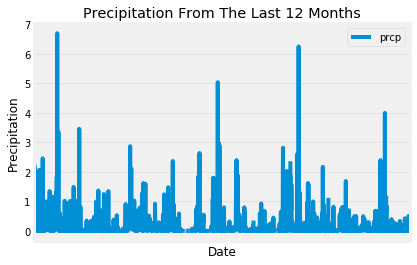

In [23]:
#use Pandas Plotting with Matplotlib to plot the data
sorted_df.plot(title="Precipitation Data")

#Format x-tick label
plt.xticks([])

# Other formatting
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.title("Precipitation From The Last 12 Months")
plt.legend(frameon=True)
plt.grid(linestyle='-', linewidth='0.5', color='lightgrey')

In [24]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sorted_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [25]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).distinct().count()

9

In [26]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [27]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active= session.query(Measurement.station, func.count(Measurement.station)).\
   group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()

masq =session.query(Measurement.station, func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
   filter(Measurement.station== most_active[0]).all()
print(f"The most active station was {masq[0][0]}. The lowest temperature recorded was {masq[0][1]}F,the highest temperature was {masq[0][2]}F, and the  average temperature was {masq[0][2]}F.")

The most active station was USC00519281. The lowest temperature recorded was 54.0F,the highest temperature was 85.0F, and the  average temperature was 85.0F.


<function matplotlib.pyplot.show(*args, **kw)>

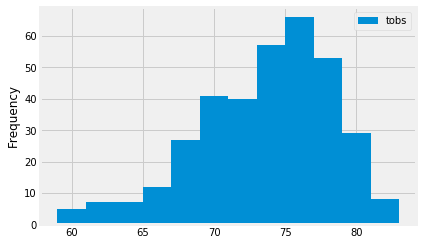

In [28]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Query temperatures
querystation = session.query(Measurement.tobs).filter(Measurement.date >= year_before_last).filter(Measurement.station=='USC00519281')
df_station = pd.DataFrame(querystation, columns=['tobs'])
df_station.plot.hist(bins=12,alpha=1)
plt.show

In [29]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [30]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
       filter(Measurement.date >= start_date).filter(Measurement.date <= latest).all()
trip_avg= calc_temps('2012-02-28', '2012-03-05')
trip_avg

[(53.0, 73.43127438710152, 87.0)]

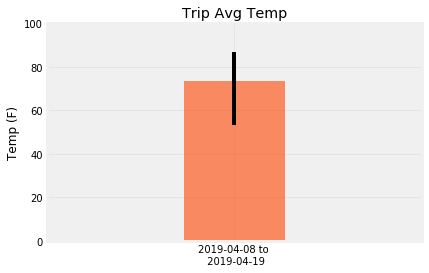

<Figure size 720x1440 with 0 Axes>

In [31]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip = '2019-04-08 to \n 2019-04-19'
tripStartDate = '2017-04-08'
tripEndDate = '2017-04-19'
tripTemps = calc_temps(tripStartDate, tripEndDate)
tripTemps
minTripTemp = trip_avg[0][0]
avgTripTemp = trip_avg[0][1]
maxTripTemp = trip_avg[0][2]
minError = avgTripTemp - minTripTemp
maxError = maxTripTemp - avgTripTemp
errorBars = np.array([[minError], [maxError]])
plt.bar(trip, avgTripTemp, yerr=errorBars, color = 'orangered', alpha = .6)
plt.ylim(0, 100)
plt.xlim(-1.5, 1.5)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.grid(alpha=.3)
plt.figure(figsize=(10,20))
plt.show()

In [42]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date_dt = dt.datetime.strptime(tripStartDate, '%Y-%m-%d')
end_date_dt = dt.datetime.strptime(tripEndDate, '%Y-%m-%d')

session.query(Measurement.station, 
              func.avg(Measurement.prcp)). \
            filter(Measurement.date.between(start_date_dt, end_date_dt)). \
            group_by(Measurement.station). \
            order_by(func.avg(Measurement.prcp).desc()).all()


[('USC00516128', 0.6709090909090909),
 ('USC00519281', 0.6345454545454544),
 ('USC00513117', 0.22545454545454546),
 ('USC00514830', 0.12285714285714286),
 ('USC00519523', 0.08099999999999999),
 ('USC00519397', 0.028181818181818186),
 ('USC00517948', 0.0)]

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
